Kleinteich and Gorb (Sci. Rep., 4, 5225, 2014) performed an interesting experiment with South American horned frogs. They held a plate connected to a force transducer, along with a bait fly, in front of them. They then measured the impact force and adhesive force of the frog's tongue when it struck the target.

Frog A is an adult and Frog B is a juvenile. The researchers measured the impact force of 20 strikes for each frog.  we will test the hypothesis that the two frogs have the same distribution of impact forces. 
The average strike force of Frog A was 0.71 Newtons (N), and that of Frog B was 0.42 N for a difference of 0.29 N. It is possible the frogs strike with the same force and this observed difference was by chance. We will compute the probability of getting at least a 0.29 N difference in mean strike force under the hypothesis that the distributions of strike forces for the two frogs are identical. We use a permutation test with a test statistic of the difference of means to test this hypothesis.

In [3]:
force_a = np.array([1.612, 0.605, 0.327, 0.946, 0.541, 1.539, 0.529, 0.628, 1.453,
       0.297, 0.703, 0.269, 0.751, 0.245, 1.182, 0.515, 0.435, 0.383,
       0.457, 0.73 ])
force_b = np.array([0.172, 0.142, 0.037, 0.453, 0.355, 0.022, 0.502, 0.273, 0.72 ,
       0.582, 0.198, 0.198, 0.597, 0.516, 0.815, 0.402, 0.605, 0.711,
       0.614, 0.468])

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
def permutation_sample(data1, data2):
    '''Generate permutation sample from two data set'''
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample1 = permuted_data[:len(data1)]
    perm_sample2 = permuted_data[len(data2):]
    return perm_sample1, perm_sample2

def draw_perm_replicates(data1, data2, func, size = 1):
    '''generate permutation replicates of data'''
    perm_replicates = np.empty(size)
    for i in range(size):
        perm1, perm2 = permutation_sample(data1, data2)
        perm_replicates[i] = func(perm1, perm2)
    return perm_replicates

def diff_of_means(data1, data2):
    return np.mean(data1) - np.mean(data2)

def bs_replicate_1d(data, func):
    bs_replicate = np.random.choice(data, size = len(data))
    return func(bs_replicate)

def draw_bs_reps(data, func, size = 1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bs_replicate_1d(data, func)
    return bs_replicates

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1)/len(x)
    return x, y

In [14]:
#DOing eda first
df = pd.DataFrame({'ID':'A',
                   'Forces':np.concatenate((force_a, force_b))})
df.iloc[20:, 0] = 'B'

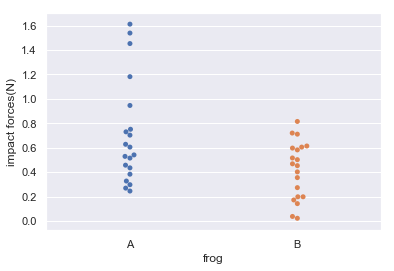

In [15]:
_ = sns.swarmplot(x = 'ID', y = 'Forces', data = df)
_ = plt.xlabel('frog')
_ = plt.ylabel('impact forces(N)')
plt.show()

it seems like the frog A have 5 high forces strike whereas forg b had some low forces strike. But we have only 20 samples so we can't say for sure that they are from a different distribution and may be the variation present here is just due to chance

(array([  12.,  135.,  564., 1444., 2336., 2560., 1834.,  841.,  230.,
          44.]),
 array([-0.40915, -0.33022, -0.25129, -0.17236, -0.09343, -0.0145 ,
         0.06443,  0.14336,  0.22229,  0.30122,  0.38015]),
 <a list of 10 Patch objects>)

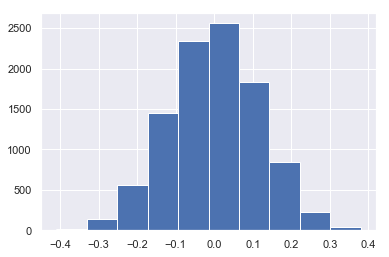

In [17]:
#Doing hypothesis testing
np.random.seed(42)
obs_diff = diff_of_means(force_a, force_b)
perm_rep_diff = draw_perm_replicates(force_a, force_b, diff_of_means, size = 10000)
plt.hist(perm_rep_diff)

In [18]:
p = np.sum(perm_rep_diff >= obs_diff)/len(perm_rep_diff)
p

0.0063

The p-value tells that there is a 0.6% of observing the mean from the experiment if both of the frogs were exactly the same. Since the p-value is less than the significant value so we will reject the null hypothesis and conclude the two frogs are different.

## A one-sample bootstrap hypothesis test
Another juvenile frog was studied, Frog C, and we want to see if Frog B and Frog C have similar impact forces. Unfortunately, we do not have Frog C's impact forces available, but we know they have a mean of 0.55 N. Because we don't have the original data, we cannot do a permutation test, and cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. we will therefore test another, less restrictive hypothesis: The mean strike force of Frog B is equal to that of Frog C.
</p>
To set up the bootstrap hypothesis test, we will take the mean as our test statistic. our goal is to calculate the probability of getting a mean impact force less than or equal to what was observed for Frog B if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true. we first translate all of the data of Frog B such that the mean is 0.55 N. This involves adding the mean force of Frog C and subtracting the mean force of Frog B from each measurement of Frog B. This leaves other properties of Frog B's distribution, such as the variance, unchanged.

In [6]:
np.random.seed(42)
#translating the impact of frog B to frog c
translated_force_b = force_b - np.mean(force_b) + 0.55

#generating bootstrap replicate
bs_mean_repl = draw_bs_reps(translated_force_b, np.mean, size = 10000)

#Generating p-value
p = np.sum(bs_mean_repl <= np.mean(force_b))/len(bs_mean_repl)
p

0.0046

since the p value is less than the significance level so we will reject the null hypothesis that frog b and c are from the same distribution

## A two-sample bootstrap hypothesis test for difference of means
We now want to test the hypothesis that Frog A and Frog B have the same mean impact force, but not necessarily the same distribution, which is also impossible with a permutation test.

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

The objects forces_concat and empirical_diff_means are already in your namespace.

In [9]:
np.random.seed(42)
#getting the observed diff
obs_diff = diff_of_means(force_a, force_b)

mean_force = np.mean(np.concatenate((force_a, force_b)))
#Shifting the data to get the same mean
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force
#generating replicates
bs_reps_force_a = draw_bs_reps(force_a_shifted, np.mean, size = 10000)
bs_reps_force_b = draw_bs_reps(force_b_shifted, np.mean, size = 10000)

bs_reps_diff = bs_reps_force_a - bs_reps_force_b

p = np.sum(bs_reps_diff >= obs_diff)/len(bs_reps_diff)
p

0.0043

We got approximately the sampe p-value as above